# import packages

In [1]:
import numpy as np
import os, glob
from netCDF4 import Dataset
import xarray, wrf
from pandas import to_datetime
from scipy.signal import welch
from scipy import fftpack
from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
fs=14
plt.rc("font",size=fs)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# define parameters

In [5]:
height = 100.0

In [6]:
filter_meters = 333.*6
kappa_cut = 1/float(filter_meters)

In [7]:
dx = {"MYNN":333.0,
       "SH":333.0,
       "VLES":333.0,
       "YSU":333.0,
       "LES_25":25.0}

In [8]:
colors = {25:'k',333:'r'}
colors = {"LES_25":"k","MYNN":"#FFC300","SH":"#FF5733","YSU":"#C70039","VLES":"#900C3F"}

In [9]:
units = {"w":"m s-1","u":"m s-1","v":"m s-1","theta":"K"}
names = {"w":"vertical velocity","u":"zonal velocity","v":"meridional velocity","theta":"potential temperature"}   

In [10]:
figPath = "/glade/u/home/doubrawa/figs/"

In [11]:
outPath = "/glade/scratch/doubrawa/post_processing/"

### define a time

In [12]:
year     = 2015
month    = 3

### the hamming filter only needs to be created once -- create it now

In [16]:
def return_hamming(Nx,Ny):

    # combo of uniform window in the middle and hamming window on edges:
    npts_buffer = 50 

    # create a 1-d hamming window : hamm_1d.shape = (100,)
    hamm_1d     = np.hamming(npts_buffer*2)
    # repeat it : B.shape = (100, 100)
    B           = np.matlib.repmat(hamm_1d,npts_buffer*2,1)
    # transpose it : C.shape = (100,100)
    C           = np.transpose(B)
    # now get the two-dimensional hamming window : hamm_2d_s.shape = (100,100)
    hamm_2d_s   = B*C

    # allocate space for the final 2d-filter
    hamm_2d = np.zeros([Ny,Nx])

    # fill it with ones (no filter) anywhere that the window won't be applied (inside the domain, anywhere inside the buffer)        
    for ii in range(0+npts_buffer,Nx-npts_buffer):
        for jj in range(0+npts_buffer,Ny-npts_buffer):
            hamm_2d[jj,ii] = 1.0

    # now put the filter values in there

    # south west corner
    hamm_2d[0:npts_buffer,0:npts_buffer] = hamm_2d_s[0:npts_buffer,0:npts_buffer]

    # south east corner
    hamm_2d[0:npts_buffer,Nx-npts_buffer:Nx] = hamm_2d_s[0:npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

    # north west corner
    hamm_2d[Ny-npts_buffer:Ny,0:npts_buffer] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,0:npts_buffer]

    # north east corner
    hamm_2d[Ny-npts_buffer:Ny,Nx-npts_buffer:Nx] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

    # south boundary
    hann_tmp = hamm_1d[0:npts_buffer]
    len_tmp  = Nx-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hann_tmp = np.transpose(hann_tmp)
    hamm_2d[0:npts_buffer,npts_buffer:Nx-npts_buffer] = hann_tmp

    # north boundary
    hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
    len_tmp  = Nx-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hann_tmp = np.transpose(hann_tmp)
    hamm_2d[Ny-npts_buffer:Ny,npts_buffer:Nx-npts_buffer] = hann_tmp

    # west boundary
    hann_tmp = hamm_1d[0:npts_buffer]
    len_tmp  = Ny-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hamm_2d[npts_buffer:Ny-npts_buffer,0:npts_buffer] = hann_tmp

    # east boundary
    hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
    len_tmp  = Ny-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hamm_2d[npts_buffer:Ny-npts_buffer,Nx-npts_buffer:Nx] = hann_tmp
    
    return hamm_2d

In [17]:
hamm_2d = return_hamming(Nx=399,Ny=399)

### prepare a butterworth filter

In [19]:
wrf_dx = 333.

n_ord = 12 # order of the Butterworth filter
x_len = 399
y_len = 399
kappas_1dx = fftpack.fftfreq(x_len,d=wrf_dx)
kappas_1dy = fftpack.fftfreq(y_len,d=wrf_dx)
[kx_2d,ky_2d] = np.meshgrid(kappas_1dx,kappas_1dy)
k_xy_2d = np.sqrt(np.power(kx_2d,2.0)+np.power(ky_2d,2.0))
BWnth_2d_f = 1.0/(np.sqrt(1.0+(np.power(k_xy_2d/kappa_cut,2*n_ord))))

In [21]:
# for each instant, read in the previously-patched LES fields and the gray zone wrfout fields

for day in [21]:
    directories = {"MYNN":"/glade/scratch/doubrawa/final_data/mynn/03{0}15/".format(day),
                   "SH":"/glade/scratch/doubrawa/final_data/sh/03{0}15/".format(day),
                   "VLES":"/glade/scratch/doubrawa/final_data/vles/03{0}15/".format(day),
                   "YSU":"/glade/scratch/doubrawa/final_data/ysu/03{0}15/".format(day),
                   "LES_25":"/glade/scratch/doubrawa/post_processing/"}    
    for hour in [15]:#np.arange(14,24,1)
        minutes = [0]#np.arange(0,59,10) if hour!=14 else np.arange(20,59,10)
        for minute in minutes:
            datetime = to_datetime("{0}-{1}-{2} {3}:{4}".format(year,month,day,hour,minute),format="%Y-%m-%d %H:%M")
            print("-----------------------")
            print(datetime)
            
            w     = {}
            ws    = {}
            u     = {}
            v     = {}
            pblh  = {}
            theta = {}
            xlat  = {}
            xlong = {}
            
            for key,directory in directories.items():
                
                if "LES_" not in key:
                    wrfouts = sorted(glob.glob(os.path.join(directory,'wrfout_d03_2015-03-{0}_{1}:{2:02d}*'.format(day,hour,minute))))
                    wrfout  = wrfouts[0]
                    print (os.path.split(wrfout)[-1])

                    wrfnc = Dataset(wrfout)
                    hgt   = wrf.getvar(wrfnc, "ter", units="m")
                    z     = wrf.getvar(wrfnc, "z", units="m")
                    zref  = z-hgt

                    w_3d   = wrf.getvar(wrfnc, "wa", units="m s-1", timeidx=0)
                    w[key] = wrf.interplevel(w_3d, zref, height, meta=True)                       
                    
                    theta_3d   = wrf.getvar(wrfnc, "theta", units="K", timeidx=0)
                    theta[key] = wrf.interplevel(theta_3d, zref, height, meta=True)                       

                    pblh[key]  = wrf.getvar(wrfnc, "PBLH", timeidx=0)                    
                    
                    xlat[key]  = wrf.getvar(wrfnc, "lat")
                    xlong[key] = wrf.getvar(wrfnc, "lon")
                    
                    ua = wrf.getvar(wrfnc,"ua", timeidx=0)
                    va = wrf.getvar(wrfnc,"va", timeidx=0)
                    u[key] = wrf.interplevel(ua, zref, height, meta=True)
                    v[key] = wrf.interplevel(va, zref, height, meta=True)
                    ws[key] = (u[key]**2+v[key]**2)**0.5                    

                else:                    
                    wrfouts = sorted(glob.glob(os.path.join(directory,'WRF_LES_25m_{0}*2015-03-{1}_{2}:{3:02d}*'.format(height,day,hour,minute))))
                    wrfout  = wrfouts[0]
                    print (os.path.split(wrfout)[-1])                
                    
                    wrfnc = xarray.open_dataset(wrfout)
                    w[key] = wrfnc["w"]
                    theta[key] = wrfnc["theta"]
                    u[key] = wrfnc['u']
                    v[key] = wrfnc['v']
                    ws[key] = (wrfnc['u']**2+wrfnc['v']**2)**0.5
                    xlat[key]  = wrfnc["lat"]
                    xlong[key] = wrfnc["lon"]


            # equivalent x/y coordinates across domains

            x = {}
            y = {}

            ref_wrfnc = Dataset("/glade/scratch/doubrawa/final_data/les/032815/032815_14UTC/wrfout_d04_2015-03-28_14:00:00_0000")

            for key in directories.keys():
                print (key)
                x[key], y[key] = wrf.ll_to_xy(ref_wrfnc, xlat[key], xlong[key])
                x[key]   = np.reshape(x[key].data,w[key].shape)
                y[key]   = np.reshape(y[key].data,w[key].shape)

            # clip all of them to the same area

            xmin, xmax = np.min(x["LES_25"]), np.max(x["LES_25"])
            ymin, ymax = np.min(y["LES_25"]), np.max(y["LES_25"])

            x_clipped     = {}
            y_clipped     = {}
            w_clipped     = {}
            u_clipped     = {}
            v_clipped     = {}
            theta_clipped = {}
            pblh_clipped  = {}
            ws_clipped    = {}
            xlat_clipped  = {}
            xlong_clipped = {}

            for key in ["MYNN","SH","YSU","VLES"]:

                condition_x = ( (x[key] >= xmin) & (x[key]<=xmax) )
                condition_y = ( (y[key] >= ymin) & (y[key]<=ymax) )
                condition   = condition_x & condition_y

                idx_sn, idx_we = np.where(condition)
                idx_sn = np.unique(idx_sn)
                idx_we = np.unique(idx_we)

                w_clipped[key]     = (w[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                u_clipped[key]     = (u[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                v_clipped[key]     = (v[key].isel(west_east=idx_we,south_north=idx_sn)).copy()    
                ws_clipped[key]    = (ws[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                pblh_clipped[key]  = (pblh[key].isel(west_east=idx_we,south_north=idx_sn)).copy()                
                theta_clipped[key] = (theta[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                x_clipped[key]     = (x[key][idx_sn,idx_we]).copy()
                y_clipped[key]     = (y[key][idx_sn,idx_we]).copy()
                xlat_clipped[key]  = (xlat[key][idx_sn,idx_we]).copy()
                xlong_clipped[key] = (xlong[key][idx_sn,idx_we]).copy()

            # for the LES_25, there is no clipping, so just make links to the original data
            x_clipped["LES_25"]     = x["LES_25"]
            y_clipped["LES_25"]     = y["LES_25"]
            u_clipped["LES_25"]     = u["LES_25"]
            v_clipped["LES_25"]     = v["LES_25"]
            w_clipped["LES_25"]     = w["LES_25"]
            theta_clipped["LES_25"] = theta["LES_25"]
            ws_clipped["LES_25"]    = ws["LES_25"]
            xlat_clipped["LES_25"]  = xlat["LES_25"]
            xlong_clipped["LES_25"] = xlong["LES_25"]
            
            for key in x_clipped.keys():
                xlat_clipped[key].attrs['projection'] = 'LambertConformal'
                xlong_clipped[key].attrs['projection'] = 'LambertConformal'                
            
            # do the filtering
            variables = [u_clipped,v_clipped,w_clipped,theta_clipped]
            varnames  = ["u","v","w","theta"]
            for key in x_clipped.keys():
                vars_filt   = {}
                data_arrays = {}
                for variable,varname in zip(variables,varnames):
                    print (varname)
                    
                    # 1. get 2-d array
                    tmp = variable[key].copy()

                    # 2. remove spatial mean
                    tmp_mean = np.mean(tmp)
                    tmp = tmp - tmp_mean

                    # 3. apply window (to minimize noise since the arrays are not periodic in space)
                    tmp = tmp*hamm_2d

                    # 4. apply fft
                    psd_2d = fftpack.fft2(tmp)

                    # 5. apply butterworth filter (instead of sharp filter, to minimize ringing effect near cut-off wavenumber)
                    psd_2d = np.squeeze(psd_2d)*BWnth_2d_f

                    # 6. invert to get the array back and put it in the kth index of the previously allocated 3-d array
                    vars_filt[varname] = fftpack.ifft2(psd_2d).real + tmp_mean
                    
                    # turn the filtered variable into an xarray dataarray
                    data_arrays[varname] = xarray.DataArray(vars_filt[varname],
                                         coords={"south_north":np.unique(np.squeeze(y_clipped[key])),"west_east":np.unique(np.squeeze(x_clipped[key]))},
                                         dims=("south_north","west_east"),
                                         name=names[varname])

                    data_arrays[varname]["XLAT"]  = xlat_clipped[key]
                    data_arrays[varname]["XLONG"] = xlong_clipped[key]                   
                    data_arrays[varname].attrs = {"unit":units[varname],"stagger":"","height [m]":height}

                # after going over all variables for this simulation approach, put them into an xarray obj
                dataset = xarray.Dataset(data_arrays)
                dataset.attrs = {'filter wavenumber':kappa_cut}

                # define a file name to save this dataset to
                try:
                    timestamp = pd.Timestamp(w[key].Time.data)
                except:
                    timestamp = pd.Timestamp(w[key].time.data[0])
                fName   = "WRF_CLIPPED_FILTERED_{0}_{1}_m_AGL_{2:%Y-%m-%d_%H:%M}.nc".format(key,height,timestamp)
                fPath   = os.path.join(outPath,fName)                
                # save it as nc file
                print ("Saving : {0}".format(fName))
                dataset.to_netcdf(fPath)                       
                break

-----------------------
2015-03-21 15:00:00
wrfout_d03_2015-03-21_15:00:00
wrfout_d03_2015-03-21_15:00:00
wrfout_d03_2015-03-21_15:00:00
wrfout_d03_2015-03-21_15:00:00


IndexError: list index out of range

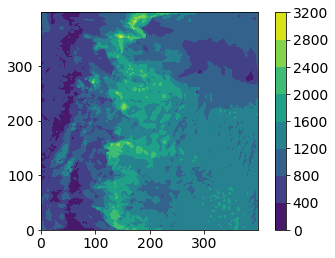

In [20]:
plt.axes(aspect='equal')
plt.contourf(pblh["MYNN"])
plt.colorbar()

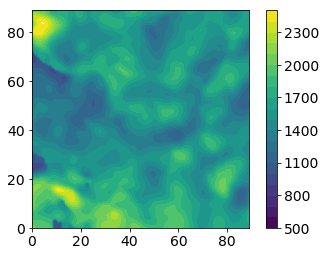

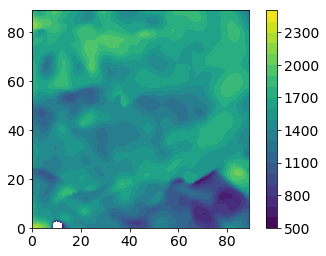

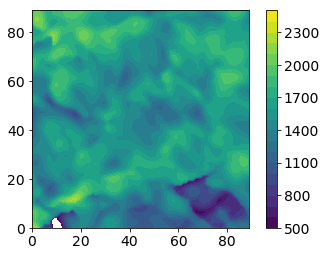

In [25]:
for key in ["MYNN","YSU","SH"]:

    plt.figure()
    plt.axes(aspect='equal')
    plt.contourf(pblh_clipped[key],levels=np.arange(500,2500.01,100))
    plt.colorbar()

In [33]:
key = 'MYNN'

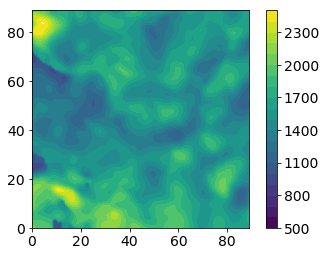

In [34]:
plt.figure()
plt.axes(aspect='equal')
plt.contourf(pblh_clipped[key],levels=np.arange(500,2500.01,100))
plt.colorbar()

In [35]:
119+178.3/2.

208.15

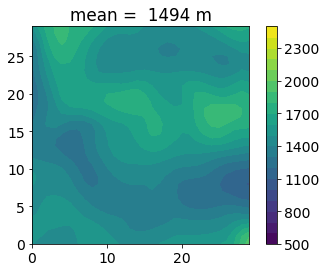

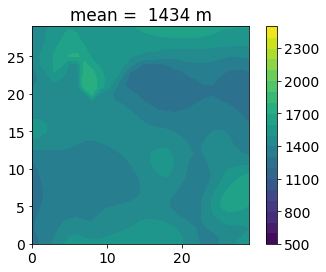

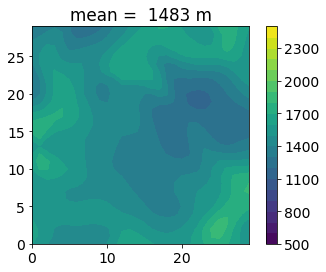

In [42]:
for key in ["MYNN","YSU","SH"]:

    plt.figure()
    plt.axes(aspect='equal')
    aaa=pblh_clipped[key].isel(south_north=np.arange(30,60,1)).isel(west_east=np.arange(30,60,1))
    plt.contourf(aaa,levels=np.arange(500,2500.01,100))
    plt.colorbar()
    plt.title("mean = {0:5.0f} m".format(np.mean(aaa.values)))

# JUNKYARD

In [ ]:
# read it back in just to check it saved it alright
ncpaths = glob.glob(os.path.join(outPath,"WRF_CLIPPED_FILTERED*.nc"))
for path in ncpaths:
    ds = xarray.open_dataset(path)
    plt.figure()
    ds['w'].plot(vmin=-1,vmax=1)
    plt.title(os.path.split(path)[-1].split('_')[3])

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


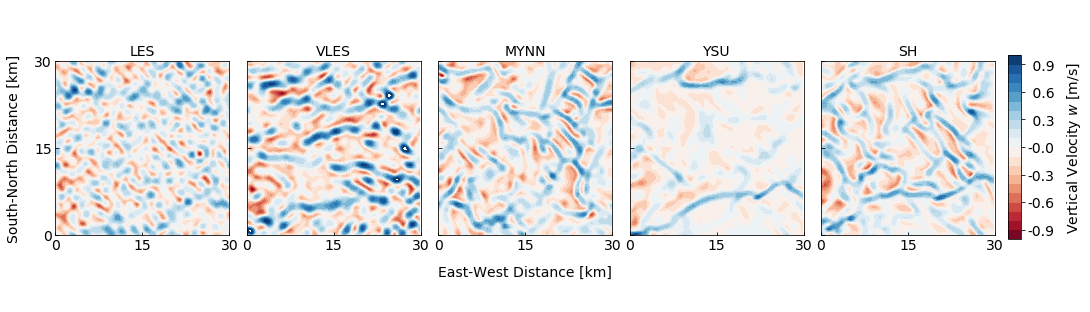

In [258]:
# vertical velocity

levels = np.arange(-1.0,1.1,0.1)
fig   = plt.figure(figsize=(18,5))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
axbig.set_xlabel("East-West Distance [km]",labelpad=-40)
axbig.set_ylabel("South-North Distance [km]",labelpad=5)

ax  = {}
for iax,key in enumerate(["LES_25","VLES","MYNN","YSU","SH"]):

    if iax==0:
        ax[iax] = fig.add_subplot(1,5,iax+1,aspect='equal')
    else:
        ax[iax] = fig.add_subplot(1,5,iax+1,sharex=ax[0],sharey=ax[0],aspect='equal')

    key_title = "LES" if key=="LES_25" else key

    ax[iax].set_title(key_title,fontsize=fs)

    if "LES" in key:
        contour = np.squeeze(v_array_filt[key])
    else:
        contour = np.squeeze(w_clipped[key])
    xx      = np.squeeze(x_clipped[key])
    yy      = np.squeeze(y_clipped[key])

    p = ax[iax].contourf(xx,yy,contour,levels=levels,cmap="RdBu")
    #p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")        

    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

    if iax>0:
        plt.setp(ax[iax].get_yticklabels(), visible=False)

    ax[iax].xaxis.set_tick_params(direction='in')
    ax[iax].yaxis.set_tick_params(direction='in')           

    fig.subplots_adjust(wspace=0.1)

    desired_ticks = [0,15,30]
    xticks        = [(ii*1000)/25.0 for ii in desired_ticks]
    ax[iax].set_xticks(xticks)
    labels = ["{0:.0f}".format(dx) for dx in desired_ticks]
    ax[iax].set_xticklabels(labels,fontsize=fs)

ax[0].set_yticks(xticks)
ax[0].set_yticklabels(labels,fontsize=fs)   

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.25, 0.01, 0.51])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%4.1f'))
clb.set_label('Vertical Velocity $w$ [m/s]', labelpad=10)

# fig.savefig(os.path.join(figPath,"contours_w_clipped_{0:%Y-%m-%d-%H-%M}_{1:.0f}m.png".format(datetime,height)),bbox_to_inches="tight",pad_inches = 0)    